In [8]:
import pandas as pd

import statsmodels.formula.api as smf
import statsmodels.api as sm

import matplotlib.pyplot as plt

In [9]:
df_main = pd.read_csv('13to17/table.csv')

df_main.head()

,Unnamed: 0,name,syncs,max_syncs,reads,writes,промахи ср,промахи ди,исп кэша ср,исп кэша ди,промахи L2 ср,промахи L2 ди,исп L2 ср,исп L2 ди,nprs_mean,nprs_ci
0,0,1_stock_8192,[0],0,[327680],[172032],4.406040e+07,1.455649e+06,1.001084e+09,5.773847e+06,4.772687e+08,2.556370e+06,5.503901e+08,3.053469e+06,0.481624,0.003467
1,1,1_depth_8192,[21],21,[327680],[172032],5.626273e+07,1.283400e+06,1.036742e+09,1.250484e+07,4.925319e+08,6.554719e+06,1.003470e+09,1.019483e+07,0.457993,0.006451
2,2,2_stock_8192,"[2, 2]",2,"[163840, 163840]","[86016, 86016]",3.129924e+07,2.040121e+06,1.958536e+09,1.967624e+07,9.301785e+08,9.865946e+06,1.069672e+09,1.134700e+07,0.232448,0.003144
3,3,2_depth_8192,"[21, 21]",21,"[163840, 163840]","[86016, 86016]",5.671937e+07,3.579942e+06,1.972877e+09,2.301866e+07,8.048176e+08,1.031118e+07,1.160746e+09,1.375568e+07,0.362217,0.004662
4,4,4_stock_8192,"[2, 2, 2, 2]",2,"[81920, 81920, 81920, 81920]","[43008, 43008, 43008, 43008]",8.819732e+07,4.980123e+06,2.760119e+09,4.519330e+07,1.298055e+09,2.178905e+07,1.490808e+09,2.481000e+07,0.159798,0.002608


In [10]:
df = df_main.copy()

df['cache_miss_ratio'] = df['промахи ср'] / df['исп кэша ср']
df['L2_miss_ratio'] = df['промахи L2 ср'] / df['исп L2 ср']
df['threads'] = df['reads'].apply(lambda x: len(eval(x)))
df['threads_inverse'] = 1. / df['threads']
df['nprs_mean_inverse'] = 1. / df['nprs_mean']

df = df[['cache_miss_ratio', 'L2_miss_ratio', 'threads', 'threads_inverse', 'nprs_mean', 'nprs_mean_inverse']]

df.head()

,cache_miss_ratio,L2_miss_ratio,threads,threads_inverse,nprs_mean,nprs_mean_inverse
0,0.044013,0.867146,1,1.00,0.481624,2.076309
1,0.054269,0.490829,1,1.00,0.457993,2.183437
2,0.015981,0.869592,2,0.50,0.232448,4.302034
3,0.028750,0.693362,2,0.50,0.362217,2.760775
4,0.031954,0.870705,4,0.25,0.159798,6.257918


NameError: name 'plt' is not defined

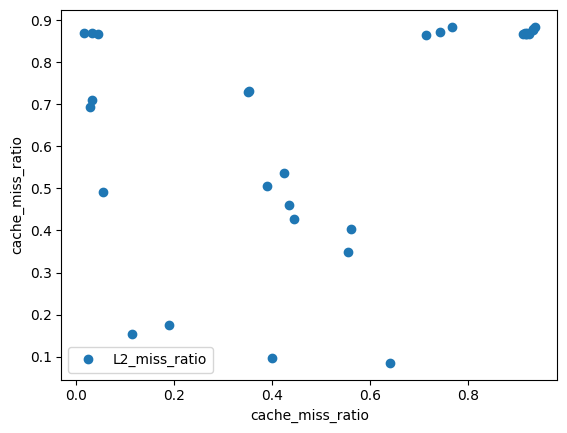

In [14]:
for key1 in ['cache_miss_ratio', 'L2_miss_ratio', 'threads_inverse', 'nprs_mean']:
    for key2 in ['cache_miss_ratio', 'L2_miss_ratio', 'threads_inverse', 'nprs_mean']:
        if key1 == key2:
            continue

        ax = df.plot(x=key1, y=key2, style='o')
        ax.set_ylabel(key1)
        plt.show()

In [4]:
df.corr()

,cache_miss_ratio,L2_miss_ratio,threads,threads_inverse,nprs_mean,nprs_mean_inverse
cache_miss_ratio,1.000000,0.379194,0.055372,-0.062155,0.584545,-0.599704
L2_miss_ratio,0.379194,1.000000,0.259257,-0.310395,-0.313613,0.244502
threads,0.055372,0.259257,1.000000,-0.928571,-0.341059,0.229022
threads_inverse,-0.062155,-0.310395,-0.928571,1.000000,0.388458,-0.240158
nprs_mean,0.584545,-0.313613,-0.341059,0.388458,1.000000,-0.859234
nprs_mean_inverse,-0.599704,0.244502,0.229022,-0.240158,-0.859234,1.000000


In [5]:
model = smf.ols(formula='nprs_mean ~ cache_miss_ratio + L2_miss_ratio + threads_inverse', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              nprs_mean   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     25.09
Date:                Sat, 18 May 2024   Prob (F-statistic):           7.68e-08
Time:                        12:47:58   Log-Likelihood:                 6.6158
No. Observations:                  30   AIC:                            -5.232
Df Residuals:                      26   BIC:                            0.3731
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.8497      0.147  